In [1]:
from SimPEG import (Utils,Mesh, Maps, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)
from SimPEG.EM.Static import SP
from SimPEG.EM.Static.Utils import StaticUtils
from matplotlib.colors import LogNorm
import discretize
from pymatsolver import Pardiso
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter 
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
matplotlib.rcParams['font.size'] = 18

In [4]:
%%time

# load TEM mesh and inverison results
datadir = "./TEM_data/"
actind = np.load(datadir + 'actind_2d.npy')
mesh_3d = Mesh.TensorMesh.readUBC(datadir+'mesh_3d.msh')
locs_tem = np.load(datadir+'locs.npy')
x_tem = locs_tem[:,0]
# m0 = np.ones(actind.sum())
datadir2 ="./TEMinversion_result/"
m0 = np.load(datadir2+'mopt.npy')

df_tem = pd.read_csv(datadir+"TEM_position.csv")
East_tem = df_tem['East'].values.copy()
North_tem = df_tem['North'].values.copy()

TAG = np.r_[517403,2890929]


# load SP positon data

topo = pd.read_excel(datadir+"bathymetric.xls").values
df_sp01 = pd.read_excel("SP01.xls")
XY_sp = np.c_[df_sp01['East_fit'].values,df_sp01['North_fit'].values]
origin_id_sp = ((XY_sp[:,0]-TAG[0])**2+(XY_sp[:,1]-TAG[1])**2).argmin()


E_24 = df_sp01['E24'].values.copy()
TempCi = df_sp01['TempCi']
Nephvoltsi = df_sp01['Nephvoltsi']
Depth_sp = df_sp01['Depth_sp']

dist_sp = np.sqrt((XY_sp[:,0]-XY_sp[origin_id_sp,0])**2+
                   (XY_sp[:,1]-XY_sp[origin_id_sp,1])**2)*np.sign(XY_sp[:,1]-XY_sp[origin_id_sp,1])
dist_tem = locs_tem[:,0]

f = interp1d(dist_sp,E_24,kind ='linear')
f1 = interp1d(dist_sp,TempCi,kind ='linear')
f2 = interp1d(dist_sp,Nephvoltsi,kind ='linear')
f3 = interp1d(dist_sp,Depth_sp,kind ='linear')

E_24_intp =f(dist_tem)
TempCi_intp =f1(dist_tem)
Nephvoltsi_intp = f2(dist_tem)
Depth_intp = f3(dist_tem)
locs = locs_tem.copy()
locs[:,2] = Depth_intp -30

Wall time: 672 ms


In [6]:
def create_tensor_mesh(
    topo,
    h = [5, 5.,5.],
    ):

    # TODO: All parameters used for generating this mesh should be input parameters
    # Currently fixed for a specific case

    dem = topo

    mesh_local = discretize.utils.mesh_builder_xyz(
        np.vstack((dem)),
        h,
        padding_distance=[[500., 500.], [500., 500.], [500., 500.]],
        base_mesh=None,
        depth_core=200,
        expansion_factor=1.3,
        mesh_type='tensor'
    )
    
    actv_local = Utils.surface2ind_topo(mesh_local, topo)
    return mesh_local, actv_local
mesh_bathmetric,actind_bathmetric =create_tensor_mesh(topo)
bathmetric_plot = Maps.InjectActiveCells(mesh_bathmetric, indActive=actind_bathmetric, valInactive=np.nan)

In [7]:
# a uniform sigma back ground, m is the output of 2D TEM, logvaule of sigma 
m0_half = np.log(0.1)*np.ones(actind.sum())

# set mesh and map
# 2d mesh for inversion 
mesh_2d = Mesh.TensorMesh([mesh_3d.hx,mesh_3d.hz],x0=[mesh_3d.x0[0],mesh_3d.x0[2]])
map_2Dto3D = Maps.Surject2Dto3D(mesh_3d)

# include the uniform seawater
actmap = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.log(3))
actmap_plot = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.nan)
actmap_q = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=-100)

expmap = Maps.ExpMap(mesh_2d)
mapping_sigma = map_2Dto3D * expmap * actmap
mapping_plot = map_2Dto3D * expmap * actmap_plot
mapping_q = map_2Dto3D * actmap_q

# set sigma model
sigma = mapping_sigma*m0
sigma_half = mapping_sigma*m0_half


In [8]:
# set survey
xyLoc_M = locs[0::]
xyLoc_N = xyLoc_M+np.r_[1.,0,0] # horizontal orentiaon electrode
rx = SP.Rx.Dipole(xyLoc_M,xyLoc_N)

# CurrentSource
#src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh_3d.nC), mesh=mesh_3d, modelType="CurrentSource")
#prob = SP.Problem_CC_Jstore(mesh_3d, sigma=sigma_half, qMap=mapping_q, Solver=Pardiso)

src = SP.Src.StreamingCurrents([rx], mesh=mesh_3d, modelType="CurrentDensity")
wires = Maps.Wires(('jsx', actmap.nP), ('jsy', actmap.nP), ('jsz', actmap.nP))
prob = SP.Problem_CC_Jstore(mesh_3d, sigma=sigma_half, 
                            jsxMap=actmap*wires.jsx, 
                            jsyMap=actmap*wires.jsy, 
                            jszMap=actmap*wires.jsz,
                            Solver=Pardiso)


survey = SP.SurveySP_store([src])
survey.pair(prob)

In [9]:
dx = 1.
def run_2d_sp_inversion(args):   
    dobs, std, eps,lp_norm,sigma_input,locs,mesh_3d = args
    # set mesh and map
    mesh_2d = Mesh.TensorMesh([mesh_3d.hx,mesh_3d.hz],x0=[mesh_3d.x0[0],mesh_3d.x0[2]])
    map_2Dto3D = Maps.Surject2Dto3D(mesh_3d)

    actmap = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.log(3))
    actmap_plot = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=np.nan)
    actmap_q = Maps.InjectActiveCells(mesh_2d, indActive=actind, valInactive=0)
    expmap = Maps.ExpMap(mesh_2d)
    mapping_sigma = map_2Dto3D * expmap * actmap
    mapping_plot = map_2Dto3D * expmap * actmap_plot
    actMap = map_2Dto3D * actmap_q
    # set survey
    xyLoc_M = locs[0::]
    #xyLoc_N = locs[1::]
    xyLoc_N = xyLoc_M+np.r_[dx,0,0]
    rx = SP.Rx.Dipole(xyLoc_M,xyLoc_N)
    if inv_q:
        src = SP.Src.StreamingCurrents([rx], L=np.ones(mesh_3d.nC), mesh=mesh_3d, modelType="CurrentSource")
        prob = SP.Problem_CC_Jstore(mesh_3d, sigma=sigma_input, qMap=mapping_q, Solver=Pardiso)
    else:
    
        src = SP.Src.StreamingCurrents([rx], mesh=mesh_3d, modelType="CurrentDensity")
        wires = Maps.Wires(('jsx', actMap.nP), ('jsy', actMap.nP), ('jsz', actMap.nP))
        prob = SP.Problem_CC_Jstore(mesh_3d, sigma=sigma_input, 
                            jsxMap=actMap*wires.jsx, 
                            jsyMap=actMap*wires.jsy, 
                            jszMap=actMap*wires.jsz,
                            Solver=Pardiso)
    
    survey = SP.SurveySP_store([src])
    survey.pair(prob)

    survey.std = std
    survey.eps = eps
    survey.dobs =dobs[0::]*dx
    
    # data misfit
    
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    weight = 1
    meshx,topoCC = StaticUtils.gettopoCC(mesh_2d,actind)
    zlocCC = Utils.mkvc(topoCC.reshape([-1,1]).repeat(mesh_2d.nCy, axis=1))
    depthweight = 1./ ((abs(mesh_2d.gridCC[:,1] - zlocCC))**weight)
    depthweight /= depthweight.max()
    depthweight = depthweight[actind] 
    
    #wr = np.sum(prob.G**2., axis=0)**0.5
    #wr = (wr/np.max(wr))

    if l2:
        
        reg_jsx = Regularization.Tikhonov(mesh_2d, mapping=wires.jsx, indActive=actind)
        reg_jsx.cell_weights = depthweight
        reg_jsy = Regularization.Tikhonov(mesh_2d, mapping=wires.jsy, indActive=actind)
        reg_jsy.cell_weights = depthweight
        reg_jsz = Regularization.Tikhonov(mesh_2d, mapping=wires.jsz, indActive=actind)
        reg_jsz.cell_weights = depthweight
        reg_jsz.alpha_s = 0.1
        reg_jsz.alpha_x = 1.
        reg_jsz.alpha_y = 1.
        reg_jsz.alpha_z =1.
        reg = reg_jsx + reg_jsy + reg_jsz        
      
    else:
        if inv_q:
            regmap = Maps.IdentityMap(nP=actmap_q.nP)
            reg = Regularization.Sparse(mesh_2d,mapping=regmap,indActive=actind,gradientType='total')
            reg.norms = lp_norm
            reg.alpha_s =1.
            reg.alpha_x =1.
            reg.alpha_y =1.
            reg.alpha_z =1.
        else:
            reg_jsx = Regularization.Sparse(mesh_2d, mapping=wires.jsx, indActive=actind)
            reg_jsy = Regularization.Sparse(mesh_2d, mapping=wires.jsy, indActive=actind)
            reg_jsz = Regularization.Sparse(mesh_2d, mapping=wires.jsz, indActive=actind)
            reg_jsx.cell_weights = depthweight
            reg_jsy.cell_weights = depthweight
            reg_jsz.cell_weights = depthweight     
            reg_jsz.alpha_x = 10.
            reg_jsz.alpha_y = 10.
            reg_jsz.norms = lp_norm
            reg_jsz.alpha_s = 1
            reg = reg_jsx + reg_jsy + reg_jsz

    # slover 
    opt = Optimization.ProjectedGNCG(maxIter=50, maxIterCG=10, tolX=1e-20, tolF=1e-20,tolG=1e-20)# ProjectedGradient ProjectedGNCG
    opt.maxIterLS = 20
    opt.LSshorten = 0.5
    if inv_q:
        Lbound = -np.inf
        Ubound = np.inf
    else:
        Lbound = np.kron(np.asarray([0, 0, -np.inf]), np.ones(actMap.nP))
        Ubound = np.kron(np.asarray([0, 0, np.inf]), np.ones(actMap.nP))

    opt.upper = 1e0
    opt.lower = Lbound
    
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    target = Directives.TargetMisfit(chifact =1.)
    betaest = Directives.BetaEstimate_ByEig(beta0_ratio=10)#10
    beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=3)
    updateprecond = Directives.UpdatePreconditioner()
    update_SensWeight = Directives.UpdateSensitivityWeights()
    save_model = Directives.SaveModelEveryIteration()
    save = Directives.SaveOutputEveryIteration(save_txt=False)
    IRLS = Directives.Update_IRLS(
        f_min_change=1e-4, minGNiter=1, maxIRLSiter = 20,
        coolingFactor=8, coolingRate=3,betaSearch=False,
        fix_Jmatrix=True,
        chifact_start = 1.,
        chifact_target =1.,
        coolEpsFact  =1.5,
        beta_tol =1e-2,
        )

    #LP only
    if l2:
        inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest, updateprecond,target,update_SensWeight,save])
    else:
        if depth_weight_true:
            inv = Inversion.BaseInversion(invProb, directiveList=[betaest, IRLS, updateprecond,save])
        else:
            inv = Inversion.BaseInversion(invProb, directiveList=[betaest, IRLS, updateprecond,update_SensWeight,save])
        

    #save iterations
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')

    #creates an initial starting model m0
                                    
    if inv_q:
        m0 = np.ones(actmap_q.nP)*0.
    else:
        m0 = np.ones(actmap_q.nP*3)*0.
    reg.mref = m0
    mopt = inv.run(m0)
    return  mopt,opt,invProb,save,survey

In [10]:
%%time

dobs = E_24_intp
std = 0.1
eps =np.abs(dobs).max()*0.05
l2 = True
inv_q = False
depth_weight_true = False

args = [dobs, std, eps, np.c_[1,2,2,2], sigma_half,locs,mesh_3d]
mopt_L2_half,opt1,invProb_L2_half,save1,survey1 = run_2d_sp_inversion(args)

args = [dobs, std, eps, np.c_[1,2.,2.,2.], sigma,locs,mesh_3d]
mopt_L2_inv,opt2,invProb_L2_inv,save2,survey2 = run_2d_sp_inversion(args)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.85e+02  4.24e+02  0.00e+00  4.24e+02    8.00e+01      0              
   1  1.85e+02  4.00e+02  6.37e-02  4.12e+02    3.59e+01      0              
   2  1.85e+02  2.49e+02  1.54e-01  2.78e+02    2.05e+01      0              
   3  3.70e+01  2.43e+02  1.50e-01  2.49e+02    3.75e+01      0              
   4  3.70e+01  1.46e+02  9.38e-01  1.81e+02    1.62e+01      0       

  33  7.78e-07  3.60e+01  2.29e+03  3.60e+01    8.26e-02      0              
  34  7.78e-07  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0              
  35  7.78e-07  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  36  1.56e-07  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  37  1.56e-07  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  38  1.56e-07  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  39  3.11e-08  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  40  3.11e-08  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  41  3.11e-08  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  42  6.22e-09  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  43  6.22e-09  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  44  6.22e-09  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0   Skip BFGS  
  45  1.24e-09  3.60e+01  2.29e+03  3.60e+01    8.39e-02      0 

In [11]:
mopts = [mopt_L2_half,mopt_L2_inv]

mopt_half_plot = np.reshape(mopts[0],(actmap_q.nP,3),order='F')[:,2]
mopt_plot = np.reshape(mopts[1],(actmap_q.nP,3),order='F')[:,2]

C:\Users\NEIL\anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
C:\Users\NEIL\anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


Text(0.01, 0.9, 'd. Inversion result')

C:\Users\NEIL\anaconda3\lib\site-packages\matplotlib\colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


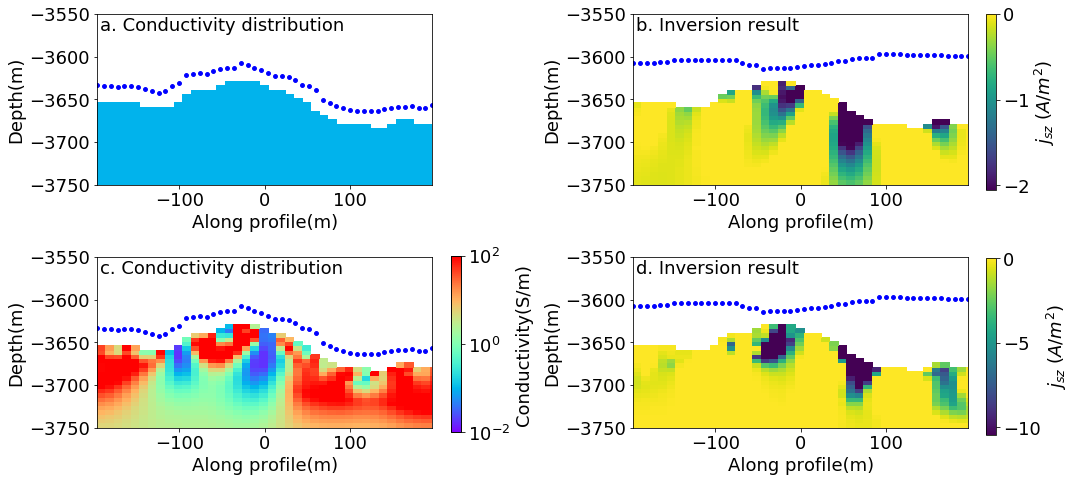

In [12]:
fig, ax = plt.subplots(2,2,figsize=(14, 7),sharex=False,sharey=False,constrained_layout=True)
ax =ax.ravel()

ylim = [-3750,-3550]
xlim = (locs[:,0].min(), locs[:,0].max()) 

clim = [0.01,1e2]
clim_sp_half = [mopt_half_plot.min()*0.3 , 0]
clim_sp = [mopt_plot.min()*0.3 , 0]


position1=fig.add_axes([0.46, 0.12, 0.01, 0.35])

cb = plt.colorbar(mesh_2d.plotImage(actmap_plot*np.exp(m0_half),ax=ax[0],# mopt_L2_half q_true
                  grid = False,clim =clim,
                  gridOpts={'alpha':0.8,'c':'gray','linewidth':0.2},
                  pcolorOpts={'norm':LogNorm(),'cmap': 'rainbow'},
                 )[0],
                  cax = position1
            )
ax[0].scatter(locs_tem[:,0], locs_tem[:,2], 15, c='b')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_xlabel('Along profile(m)')
ax[0].set_ylabel('Depth(m)')


position=fig.add_axes([0.99, 0.6, 0.01, 0.35])
cb = plt.colorbar(mesh_2d.plotImage(actmap_plot*mopt_half_plot ,clim=clim_sp_half,ax=ax[1],# mopt_L2_half q_true
                  grid = False,
                  gridOpts={'alpha':0.8,'c':'gray','linewidth':0.2},
                  #pcolorOpts={'norm':LogNorm(),'cmap':'coolwarm'},
                 )[0],
                  ax = ax[1],
                  cax = position
            )
ax[1].scatter(locs[:,0], locs[:,2], 15, c='b')

cb.set_label('$j_{sz}$ ($A/m^2$)')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_ylabel('Depth(m)')
ax[1].set_xlabel('Along profile(m)')

cb = plt.colorbar(mesh_2d.plotImage(actmap_plot*np.exp(m0),ax=ax[2],# mopt_L2_half q_true
                  grid = False,clim =clim,
                  gridOpts={'alpha':0.8,'c':'gray','linewidth':0.2},
                  pcolorOpts={'norm':LogNorm(),'cmap': 'rainbow'},
                 )[0]
                  ,cax = position1
            )
ax[2].scatter(locs_tem[:,0], locs_tem[:,2], 15, c='b')
ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)
ax[2].set_xlabel('Along profile(m)')
ax[2].set_ylabel('Depth(m)')
cb.set_label('Conductivity(S/m)')

position=fig.add_axes([0.99, 0.115, 0.01, 0.35])
cb = plt.colorbar(mesh_2d.plotImage(actmap_plot*mopt_plot,clim=clim_sp,ax=ax[3],# mopt_L2_half q_true
                  grid = False,
                  gridOpts={'alpha':0.8,'c':'gray','linewidth':0.2},
                  #pcolorOpts={'norm':LogNorm(),'cmap':'coolwarm'},
                 )[0],
                  ax = ax[3],
                  cax = position,
            )
cb.set_label('$j_{sz}$ ($A/m^2$)')

ax[3].scatter(locs[:,0], locs[:,2], 15, c='b')

ax[3].set_xlim(xlim)
ax[3].set_ylim(ylim)
ax[3].set_ylabel('Depth(m)')
ax[3].set_xlabel('Along profile(m)')

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[2].set_aspect('equal')
ax[3].set_aspect('equal')
plt.tight_layout(pad=1,w_pad=6.0)

ax[0].text(0.01, 0.9, "a. Conductivity distribution", transform=ax[0].transAxes)
ax[1].text(0.01, 0.9, "b. Inversion result", transform=ax[1].transAxes)
ax[2].text(0.01, 0.9, "c. Conductivity distribution", transform=ax[2].transAxes)
ax[3].text(0.01, 0.9, "d. Inversion result", transform=ax[3].transAxes)

#fig.savefig('Figure8.eps', dpi=600,bbox_inches="tight")

Text(-0.1, 0.28, 'd.')

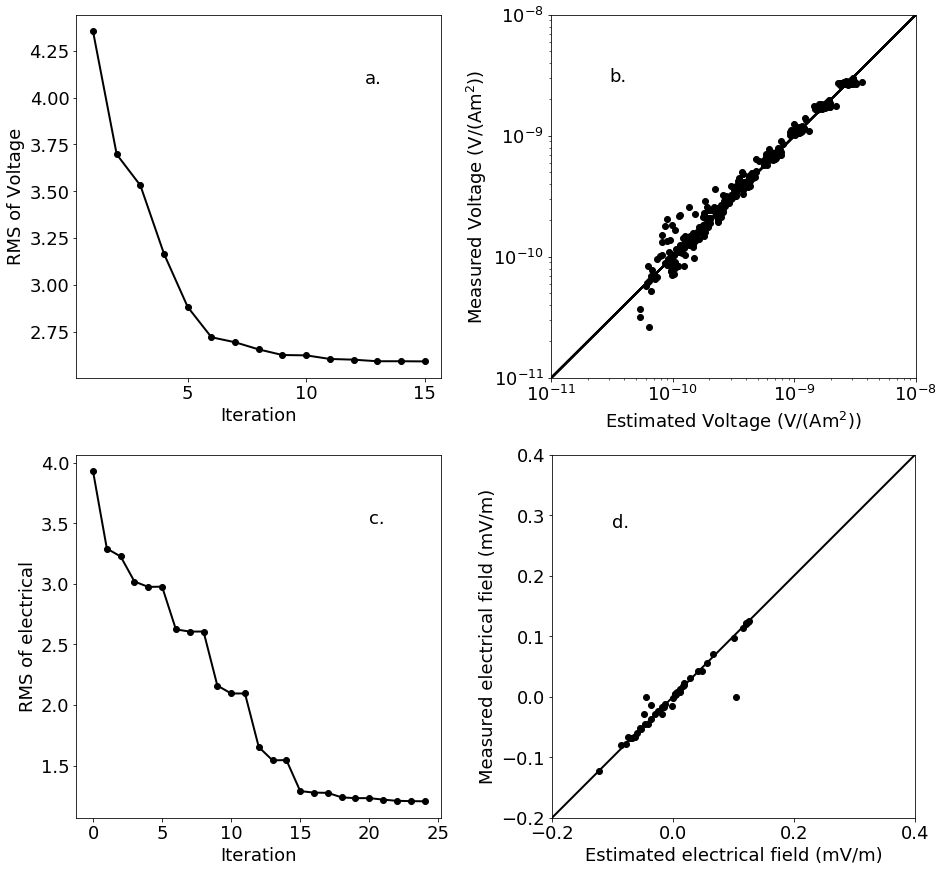

In [17]:
results = np.load(datadir2+'results.npy')
DPRED = np.load(datadir2+'DPRED.npy')
DOBS = np.load(datadir2+'DOBS.npy')
time = np.load(datadir+'times.npy')
DPRED = DPRED.reshape(50,8)
DOBS = DOBS.reshape(50,8)

fig, ax = plt.subplots(2,2,figsize=(13, 12),sharex=False,sharey=False,constrained_layout=True)
ax =ax.ravel()

ax[0].plot(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'ko',linewidth=2)
ax[0].plot(results[:,0], np.sqrt(results[:,2]/ ((x.size*time.size)/2.)), 'k',linewidth=2)

ax[0].set_xlabel("Iteration")
ax[0].set_ylabel('RMS of Voltage')


#ax[0].grid(which='both', alpha=0.2)
ax[0].text(12.5,4.075,'a.')

for itime in range(time.size):
    ax[1].loglog(-DPRED[:,itime], -DOBS[:,itime], 'ko',linewidth=2)
    ax[1].loglog([1e-11,1e-8],[1e-11,1e-8], 'k', linewidth=2)
ax[1].set_xlim(1e-11,1e-8)  
ax[1].set_ylim(1e-11,1e-8) 
ax[1].set_xlabel('Estimated Voltage (V/(Am$^2$))')
ax[1].set_ylabel('Measured Voltage (V/(Am$^2$))')
#ax[1].grid(which="both", alpha=0.2)
ax[1].text(3e-11,2.8e-9,'b.')


Lp_calculated = survey2.dpred(invProb_L2_inv.model)
Lp_calculated_half = survey1.dpred(invProb_L2_half.model)
results = save2.phi_d
rms = np.sqrt(results/ (survey2.nD/2))
iteration = np.arange(len(rms))


ax[2].plot(iteration[0:25],rms[0:25],'k',marker='o',linewidth=2)
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('RMS of electrical')
ax[2].text(20,3.5,'c.')
#ax[0].grid(which='both', alpha=0.2)
#ax[0].set_xticks(iteration)

ax[3].plot(dobs,Lp_calculated,'ko',linewidth=3)
ax[3].plot([-0.2,0.4],[-0.2,0.4],'k-', linewidth=2)
ax[3].set_xlabel('Estimated electrical field (mV/m)')
ax[3].set_ylabel('Measured electrical field (mV/m)')
ax[3].set_xlim(-0.2,0.4)
ax[3].set_ylim(-0.2,0.4)
ax[3].set_aspect('equal')
#ax[1].text(0.125,-0.05,'R=0.96')
ax[3].text(-0.1,0.28,'d.')

#fig.savefig('Figure9.jpg', dpi=600,bbox_inches="tight")

Text(-0.125, 0.33, 'd.')

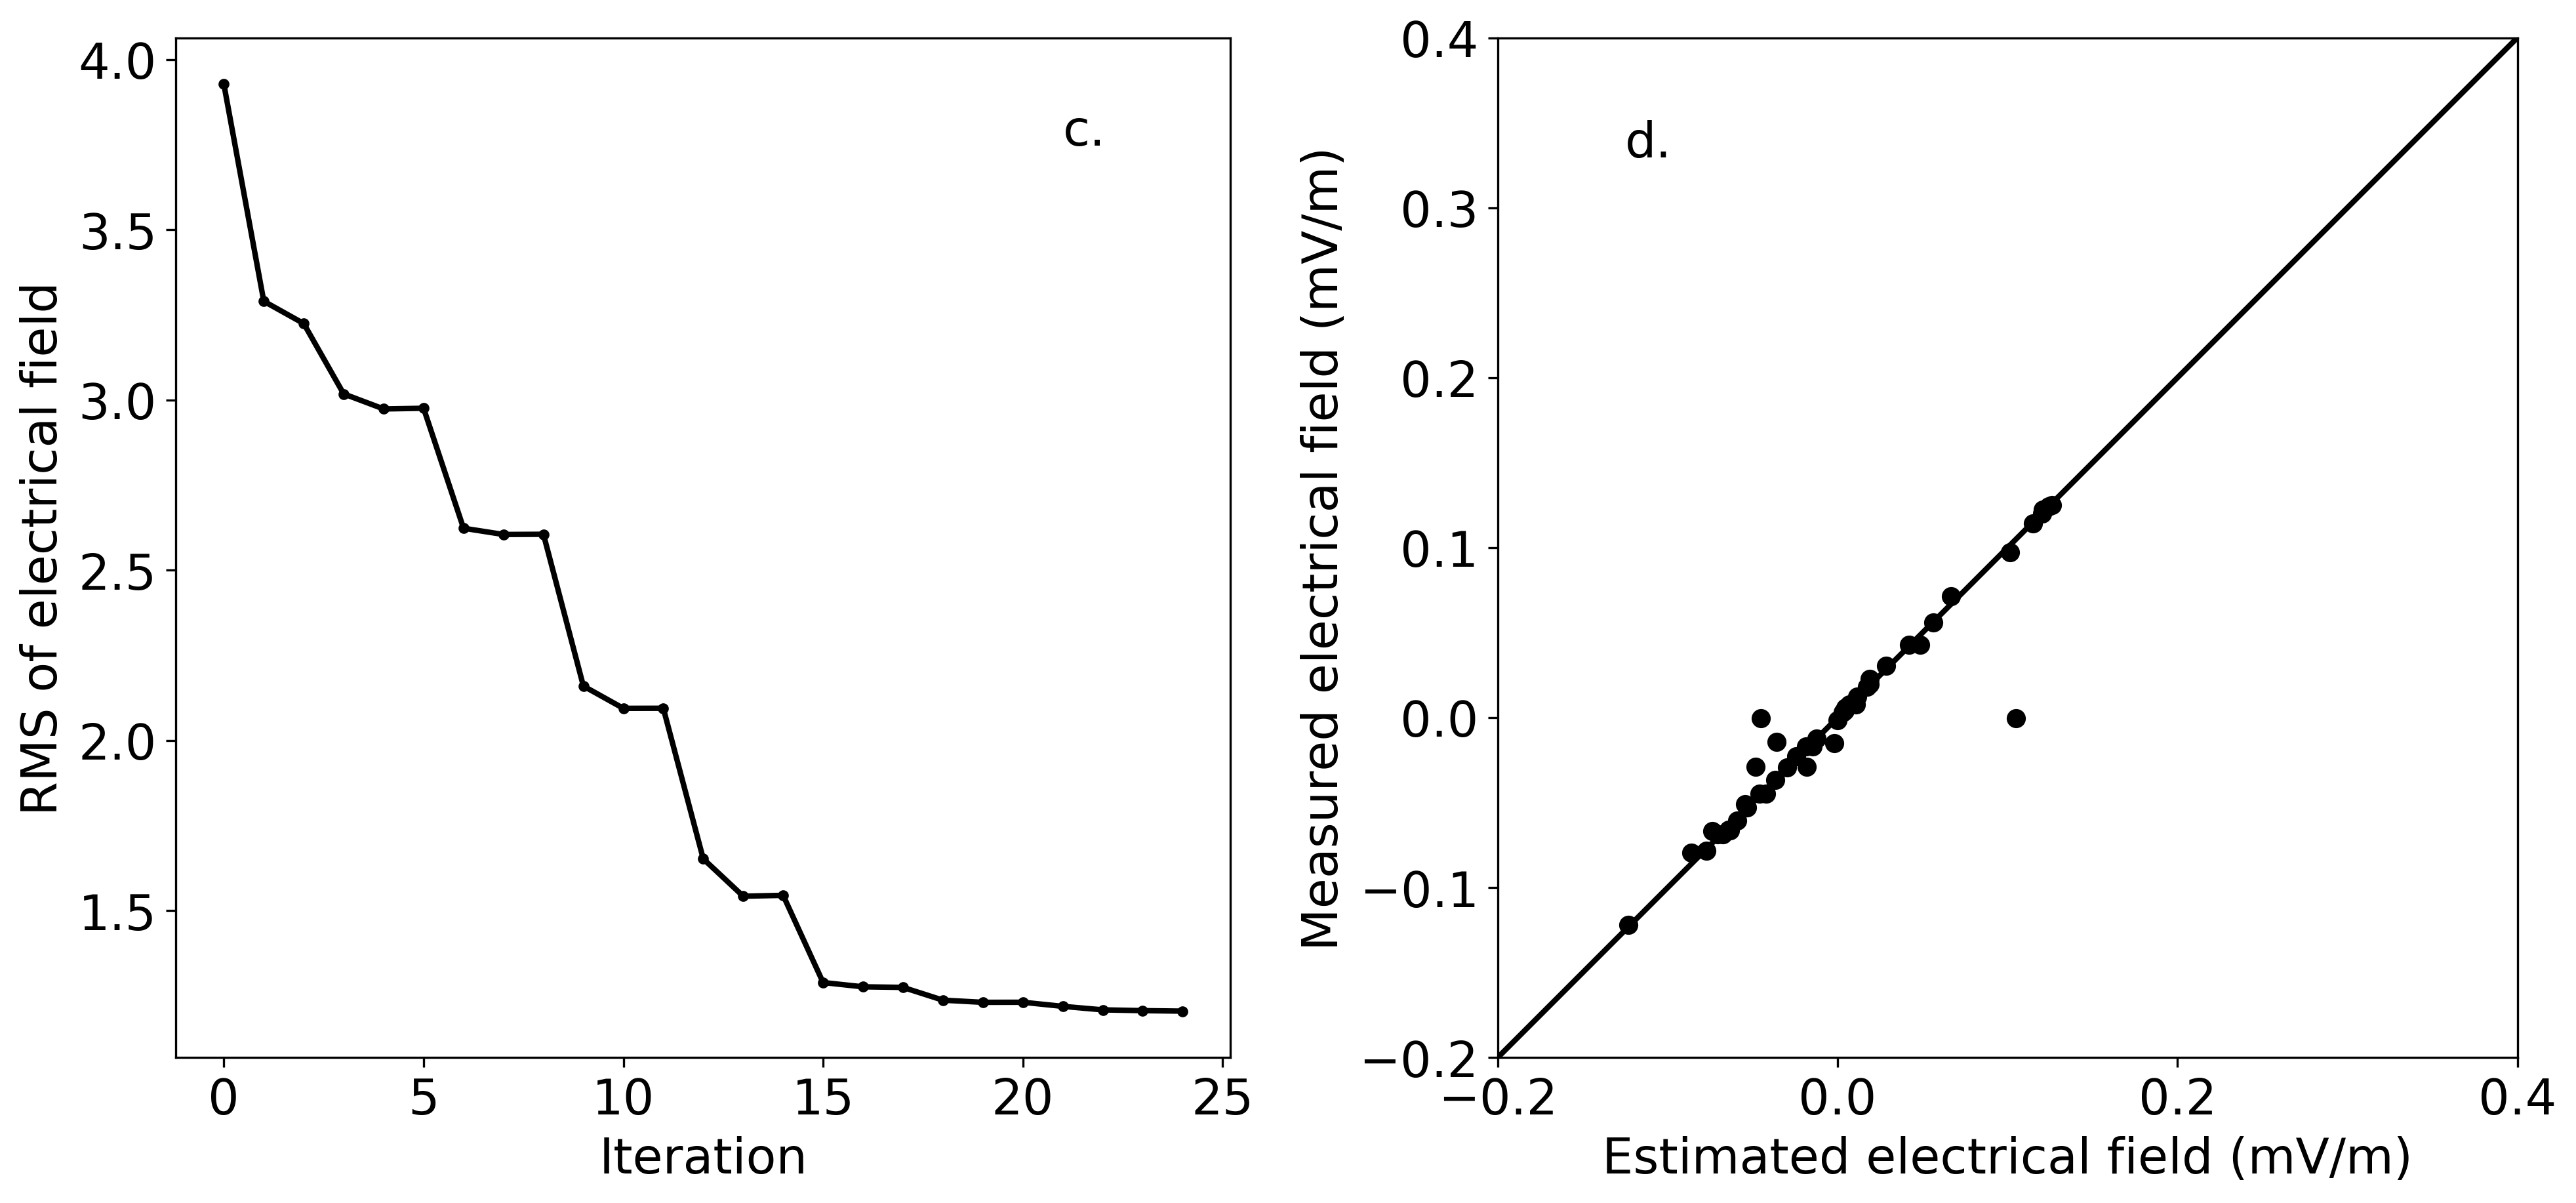

In [18]:
Lp_calculated = survey2.dpred(invProb_L2_inv.model)
Lp_calculated_half = survey1.dpred(invProb_L2_half.model)
results = save2.phi_d

rms = np.sqrt(results/ (survey2.nD/2))
iteration = np.arange(len(rms))

fig,ax = plt.subplots(1,2,figsize = (13,6),constrained_layout=True,dpi=300)

ax[0].plot(iteration[0:25],rms[0:25],'k',marker='.',linewidth=2)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('RMS of electrical field')
ax[0].text(21,3.75,'c.')
#ax[0].grid(which='both', alpha=0.2)
#ax[0].set_xticks(iteration)

ax[1].plot(dobs,Lp_calculated,'ko',linewidth=2)
ax[1].plot([-0.2,0.4],[-0.2,0.4],'k-', linewidth=2)
ax[1].set_xlabel('Estimated electrical field (mV/m)')
ax[1].set_ylabel('Measured electrical field (mV/m)')
ax[1].set_xlim(-0.2,0.4)
ax[1].set_ylim(-0.2,0.4)
ax[1].set_aspect('equal')
#ax[1].text(0.125,-0.05,'R=0.96')
ax[1].text(-0.125,0.33,'d.')
#ax[1].grid(which='both', alpha=0.2)
#fig.savefig('./Thesis_figures/c6_3d_AUV.jpg',bbox_inches="tight")
#np.corrcoef(survey.dobs,Lp_calculated)
#fig.savefig('inversionsp.png', dpi=600, bbox_inches="tight")

In [19]:
sigma_nomalization = m0/m0.max()
sp_nomalization = mopt_plot/np.abs(mopt_plot.min())
TEM_SP = sigma_nomalization*sp_nomalization

In [20]:
hx = [(5, 5, -1.3), (1, 300), (5, 5, 1.3)]
hy = [(5, 5, -1.3), (1, 300), (5, 5, 1.3)]